In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [3]:
stocks = pd.concat([aapl,cisco,ibm,amzn], axis=1)

In [4]:
stocks.columns = ['aapl','cisco','ibm','amzn']

In [5]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [6]:
stocks.pct_change().mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [7]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [8]:
log_ret = np.log(stocks/stocks.shift(1))

In [10]:
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


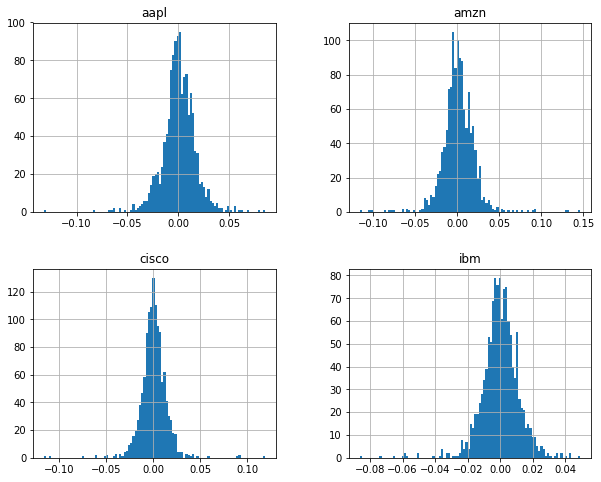

In [12]:
log_ret.hist(bins = 100, figsize=(10,8));

In [13]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [15]:
log_ret.cov() *252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [25]:
np.random.seed(101)
num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    all_weights[ind,:] = weights

    ret_arr[ind] = np.sum( (log_ret.mean() * weights ) * 252 )

    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252, weights)))

    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


In [26]:
sharpe_arr.max()

1.0303260551271067

In [27]:
sharpe_arr.argmax()

1420

In [31]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

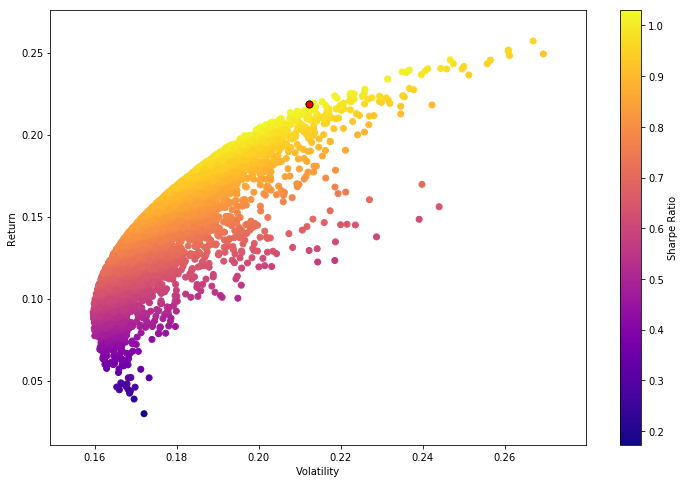

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility'); plt.ylabel('Return');
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black');

In [34]:
def get_ret_vol_sr(weights) :
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights ) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [35]:
from scipy.optimize import minimize

In [36]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized. Must be in the form
        ``f(x, *args)``. The optimizing argument, ``x``, is a 1-D array
        of points, and ``args`` is a tuple of any additional fixed parameters
        needed 

In [37]:
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

In [38]:
def check_sum(weights):
    return np.sum(weights) - 1

In [39]:
cons = ({'type' : 'eq', 'fun' : check_sum})

In [40]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [41]:
init_guess = [0.25,0.25,0.25,0.25]

In [42]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP',bounds= bounds, constraints=cons )

In [43]:
opt_results

     fun: -1.0307168703342362
     jac: array([ 5.64455986e-05,  4.18573618e-05,  3.39921728e-01, -4.44948673e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289774e-01, 2.04189831e-01, 7.52707358e-17, 5.29520395e-01])

In [44]:
opt_results.x

array([2.66289774e-01, 2.04189831e-01, 7.52707358e-17, 5.29520395e-01])

In [45]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [46]:
frontier_y = np.linspace(0,0.3,100)

In [47]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [49]:
frontier_volatility = []
for possible_return in frontier_y:
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, init_guess, method = 'SLSQP', bounds = bounds, constraints=cons)
    
    frontier_volatility.append(result['fun'])
    

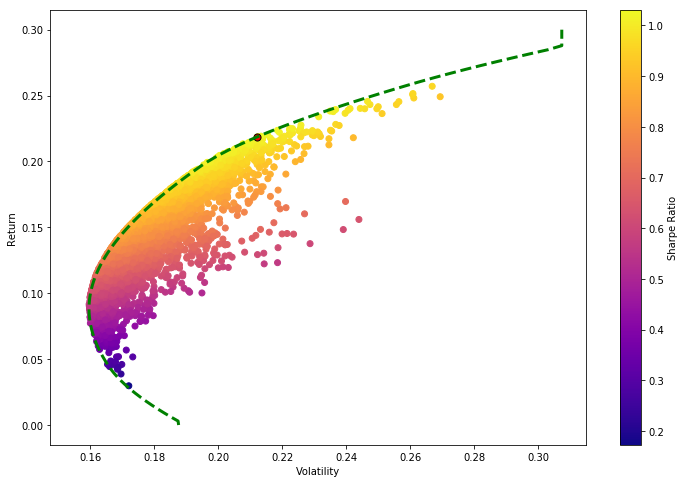

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility'); plt.ylabel('Return');
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black');

plt.plot(frontier_volatility,frontier_y,'g--',linewidth = 3)